In [1]:
##Author: Carson YAN, Jianling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew

In [2]:
train = pd.read_csv('train.csv')
# train.pd.read_csv('.../data/train.csv')
test = pd.read_csv('test.csv')
# test.pd.read_csv('.../data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 11 columns):
id                        357 non-null int64
playtime_forever          357 non-null float64
is_free                   357 non-null bool
price                     357 non-null float64
genres                    357 non-null object
categories                357 non-null object
tags                      357 non-null object
purchase_date             355 non-null object
release_date              357 non-null object
total_positive_reviews    355 non-null float64
total_negative_reviews    355 non-null float64
dtypes: bool(1), float64(4), int64(1), object(5)
memory usage: 28.4+ KB


In [4]:
# change dtypes of purchase_date and release-dat
train['purchase_date'] = train['purchase_date'].astype('datetime64[ns]')
train['release_date'] = train['release_date'].astype('datetime64[ns]')
test['purchase_date'] = test['purchase_date'].astype('datetime64[ns]')
test['release_date'] = test['release_date'].astype('datetime64[ns]')

In [5]:
train_ID = train['id']
test_ID = test['id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

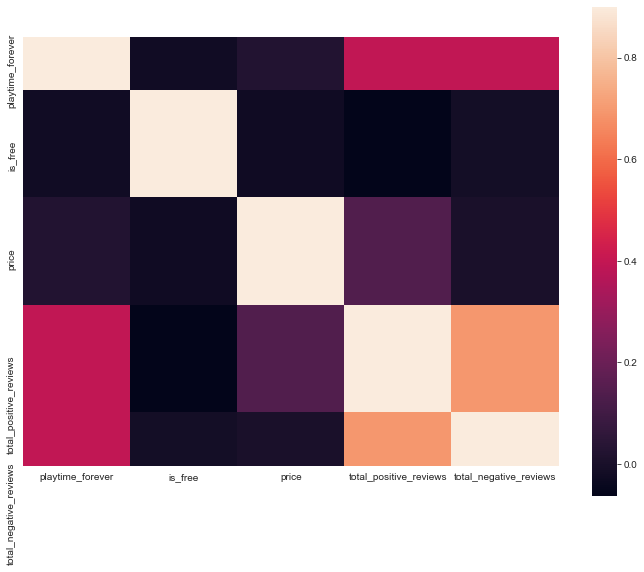

In [6]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [7]:
ntrain = train.shape[0] # # of training set
ntest = test.shape[0] # # of testing set
y_train = train.playtime_forever.values # Y of training set
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['playtime_forever'], axis=1, inplace=True)
print("size of all_data : {}".format(all_data.shape))

size of all_data : (447, 9)


Text(0.5, 1.0, 'Percent missing data by feature')

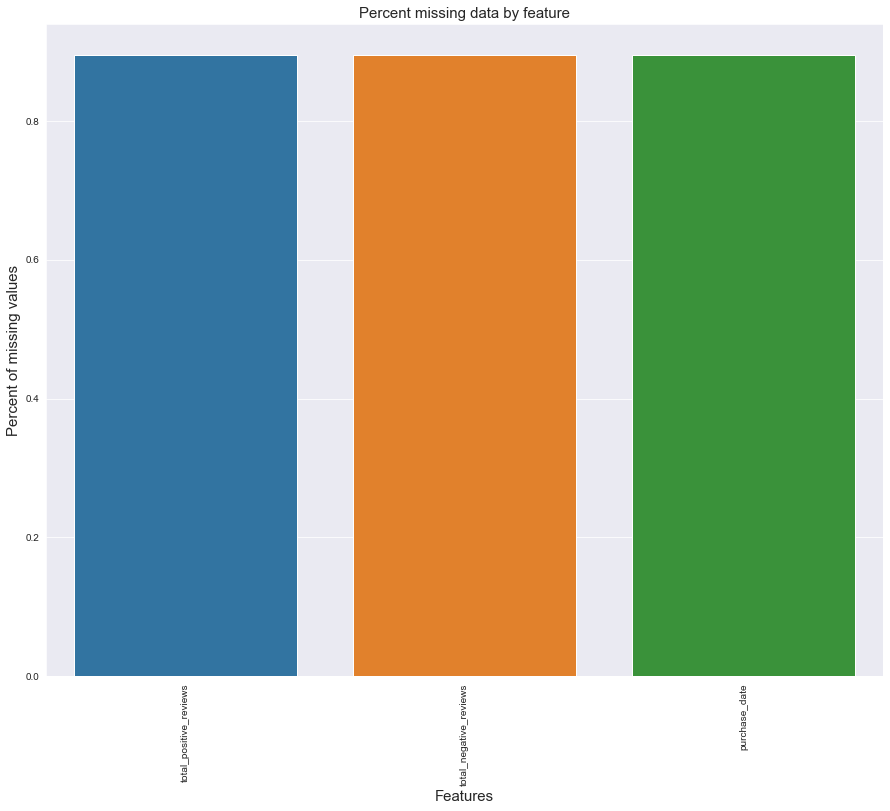

In [8]:
# check missing features
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

# show missing features
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [9]:
# deal with missing features data
for col in ('total_positive_reviews', 'total_negative_reviews'):
    all_data[col] = all_data[col].fillna(0)

all_data['purchase_date'] = all_data['purchase_date'].fillna(pd.Timestamp('2019-11-30'))

In [10]:
# check missing features again
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [11]:
# deal with purchase_date, release_date(datetime64[ns])
# result['year']=date.year 
# result['month']=date.month 
# result['dayofyear']=date.dayofyear 
purchase_date = all_data['purchase_date']
purchase_date=pd.DatetimeIndex(purchase_date)
all_data['purchase_year'] = purchase_date.year
all_data['purchase_month'] = purchase_date.month
all_data['purchase_day_of_year'] = purchase_date.dayofyear

release_date = all_data['release_date']
release_date=pd.DatetimeIndex(release_date)
all_data['release_year'] = release_date.year
all_data['release_month'] = release_date.month
all_data['release_day_of_year'] = release_date.dayofyear

# grassing_days = purchase_date - release_date
all_data['grassing_days'] = pd.DataFrame(all_data['purchase_date'] - all_data['release_date'])
all_data['grassing_days'] = all_data['grassing_days'] / np.timedelta64(1, 'D') # timedelta64 to float64

# drop purchase_date and release_date
all_data.drop(['purchase_date'], axis = 1, inplace=True)
all_data.drop(['release_date'], axis = 1, inplace=True)

In [12]:
all_data.head()

,categories,genres,is_free,price,tags,total_negative_reviews,total_positive_reviews,purchase_year,purchase_month,purchase_day_of_year,release_year,release_month,release_day_of_year,grassing_days
0,"Single-player,Steam Trading Cards,Steam Cloud","Adventure,Casual,Indie",False,3700.0,"Indie,Adventure,Story Rich,Casual,Atmospheric,...",96.0,372.0,2018,7,183,2013,12,344,1665.0
1,"Single-player,Partial Controller Support",RPG,True,0.0,"Mod,Utilities,RPG,Game Development,Singleplaye...",0.0,23.0,2016,11,331,2015,8,224,472.0
2,"Single-player,Full controller support,Steam Tr...","Adventure,Casual,Indie",False,5000.0,"Point & Click,Adventure,Story Rich,Comedy,Indi...",663.0,3018.0,2018,7,183,2014,1,28,1616.0
3,"Single-player,Multi-player,Steam Achievements,...","Action,RPG",False,9900.0,"Medieval,RPG,Open World,Strategy,Sandbox,Actio...",1746.0,63078.0,2016,11,333,2010,3,90,2434.0
4,"Single-player,Co-op,Steam Achievements,Full co...","Action,Indie,Strategy",False,4800.0,"Tower Defense,Co-op,Action,Strategy,Online Co-...",523.0,8841.0,2018,3,63,2012,7,212,2043.0


In [13]:
# create features positive/negative reviews ratio
all_data['positive_reviews_ratio'] = all_data['total_positive_reviews']/(all_data['total_positive_reviews']+all_data['total_negative_reviews']+0.0001)
all_data['negative_reviews_ratio'] = all_data['total_negative_reviews']/(all_data['total_positive_reviews']+all_data['total_negative_reviews']+0.0001)

print(all_data['positive_reviews_ratio'].head(5),'\n', all_data['negative_reviews_ratio'].head(5))

0    0.794872
1    0.999996
2    0.819886
3    0.973066
4    0.944148
Name: positive_reviews_ratio, dtype: float64 
 0    0.205128
1    0.000000
2    0.180114
3    0.026934
4    0.055852
Name: negative_reviews_ratio, dtype: float64


In [14]:
#code for 'is_free'
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
lbl.fit(list(all_data['is_free'].values))
all_data['is_free'] = lbl.transform(list(all_data['is_free'].values))
all_data.head()

,categories,genres,is_free,price,tags,total_negative_reviews,total_positive_reviews,purchase_year,purchase_month,purchase_day_of_year,release_year,release_month,release_day_of_year,grassing_days,positive_reviews_ratio,negative_reviews_ratio
0,"Single-player,Steam Trading Cards,Steam Cloud","Adventure,Casual,Indie",0,3700.0,"Indie,Adventure,Story Rich,Casual,Atmospheric,...",96.0,372.0,2018,7,183,2013,12,344,1665.0,0.794872,0.205128
1,"Single-player,Partial Controller Support",RPG,1,0.0,"Mod,Utilities,RPG,Game Development,Singleplaye...",0.0,23.0,2016,11,331,2015,8,224,472.0,0.999996,0.000000
2,"Single-player,Full controller support,Steam Tr...","Adventure,Casual,Indie",0,5000.0,"Point & Click,Adventure,Story Rich,Comedy,Indi...",663.0,3018.0,2018,7,183,2014,1,28,1616.0,0.819886,0.180114
3,"Single-player,Multi-player,Steam Achievements,...","Action,RPG",0,9900.0,"Medieval,RPG,Open World,Strategy,Sandbox,Actio...",1746.0,63078.0,2016,11,333,2010,3,90,2434.0,0.973066,0.026934
4,"Single-player,Co-op,Steam Achievements,Full co...","Action,Indie,Strategy",0,4800.0,"Tower Defense,Co-op,Action,Strategy,Online Co-...",523.0,8841.0,2018,3,63,2012,7,212,2043.0,0.944148,0.055852


In [15]:
#one-hot encode
all_data = pd.get_dummies(all_data)
all_data.head()

,is_free,price,total_negative_reviews,total_positive_reviews,purchase_year,purchase_month,purchase_day_of_year,release_year,release_month,release_day_of_year,...,"tags_Walking Simulator,Adventure,Story Rich,Sci-fi,Female Protagonist,Indie,Space,First-Person,Exploration,Atmospheric,Singleplayer,Mystery,Futuristic,Short,Cyberpunk,Illuminati,Casual,Great Soundtrack,LGBTQ+,Psychological Horror","tags_Western,FPS,Action,Story Rich,Bullet Time,Shooter,Singleplayer,Comedy,First-Person,Narration,Adventure,Atmospheric,Great Soundtrack,Dynamic Narration,Funny,Arcade,Historical,Alternate History,Gore,Linear","tags_Western,Pixel Graphics,Open World,Indie,Adventure,Action,Detective,Local Co-Op,Retro,Great Soundtrack,Singleplayer,2D,RPG","tags_Western,Turn-Based Strategy,Strategy,RPG,Turn-Based Combat,Adventure,Turn-Based,Tactical,Indie,Turn-Based Tactics,Horror,Action,Singleplayer,Isometric,Atmospheric,Gore,Survival,Kickstarter,Open World,Third Person","tags_World War I,Multiplayer,FPS,Action,Realistic,War,Historical,Violent,Shooter,Strategy,Military,Gore,Indie,First-Person,Singleplayer,Simulation,Atmospheric,Early Access,Survival,Co-op","tags_Zombies,Co-op,FPS,Multiplayer,Shooter,Action,Online Co-Op,Survival,Horror,First-Person,Gore,Team-Based,Moddable,Survival Horror,Post-apocalyptic,Singleplayer,Adventure,Local Co-Op,Replay Value,Tactical","tags_Zombies,Platformer,Indie,Action,Post-apocalyptic,Adventure,Atmospheric,Side Scroller,Singleplayer,Parkour,2D,Survival,Horror,2.5D,Puzzle,Great Soundtrack,Controller,Story Rich,Short,Masterpiece","tags_Zombies,Survival,Open World,Base Building,Action,Post-apocalyptic,Singleplayer,RPG,Third Person,Simulation,Multiplayer,Sandbox,Survival Horror,Atmospheric,Crafting,Gore,Adventure,Co-op,Perma Death,Great Soundtrack","tags_Zombies,Survival,Open World,Parkour,Co-op,Multiplayer,Action,First-Person,Horror,Gore,Survival Horror,Crafting,FPS,Adventure,Atmospheric,Singleplayer,Shooter,RPG,Stealth,Sandbox","tags_Zombies,VR,Horror,Action,Multiplayer,FPS,Adventure,Survival,Indie,Gore,Survival Horror,Shooter,First-Person,Open World,Violent,Co-op,Singleplayer,Post-apocalyptic,Funny,Difficult"
0,0,3700.0,96.0,372.0,2018,7,183,2013,12,344,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0.0,23.0,2016,11,331,2015,8,224,...,0,0,0,0,0,0,0,0,0,0
2,0,5000.0,663.0,3018.0,2018,7,183,2014,1,28,...,0,0,0,0,0,0,0,0,0,0
3,0,9900.0,1746.0,63078.0,2016,11,333,2010,3,90,...,0,0,0,0,0,0,0,0,0,0
4,0,4800.0,523.0,8841.0,2018,3,63,2012,7,212,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# check missing features again
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [17]:
# get train and test
train = all_data[:ntrain]
test = all_data[ntrain:]

In [18]:
train.shape

(357, 815)

In [19]:
y_train.shape

(357,)

In [20]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# 10 fold cross val
n_folds = 10

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [21]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [22]:
score = rmse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 10.3177 (5.2028)



In [23]:
# do not set arguments manually
pure_xgb = xgb.XGBRegressor()

In [24]:
score = rmse_cv(pure_xgb)
print("Pure Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[23:17:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [25]:
model_lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [26]:
score = rmse_cv(model_lgbm)
print("lgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lgb score: 10.4702 (4.9628)



In [27]:
# do not set arguments manually
pure_lgb = lgb.LGBMRegressor()

In [28]:
score = rmse_cv(pure_lgb)
print("Pure lgb score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Pure lgb score: 9.5980 (4.7246)



In [29]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)

In [30]:
score = rmse_cv(lasso)
print("lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(Net)
print("Net score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(KRR)
print("KRR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmse_cv(GBoost)
print("GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lasso score: 9.7250 (4.8149)

Net score: 9.6140 (4.6177)

KRR score: 1322.8703 (2932.2071)

GBoost score: 9.4317 (5.2147)



In [31]:
'''
Net score: 9.6140 (4.6177)
Pure lgb score: 9.5980 (4.7246)
GBoost score: 9.4317 (5.2147)
'''

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # clone the original model
        self.models_ = [clone(x) for x in self.models]
        # fit cloned model
        for model in self.models_:
            model.fit(X, y)
        return self

    # use the cloned model to predict and get average
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) \
        for model in self.models_])
        return np.mean(predictions, axis=1)

In [32]:
averaged_models = AveragingModels(models = (GBoost, pure_lgb))

score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 9.1647 (5.0084)



In [33]:
# Stacking
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=10):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [35]:
stacked_averaged_models = StackingAveragedModels(base_models = (Net, lasso), meta_model = GBoost)

score = rmse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 9.9737 (5.3133)


In [36]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [37]:
# stacking
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = stacked_averaged_models.predict(test.values)
print(rmse(y_train, stacked_train_pred))

11.278993198754197


In [38]:
# xgb
pure_xgb.fit(train, y_train)
xgb_train_pred = pure_xgb.predict(train)
xgb_pred = pure_xgb.predict(test)
print(rmse(y_train, xgb_train_pred))

[23:22:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2.551417598007028


In [39]:
# lgb
pure_lgb.fit(train, y_train)
lgb_train_pred = pure_lgb.predict(train)
lgb_pred = pure_lgb.predict(test.values)
print(rmse(y_train, lgb_train_pred))

5.878067859804681


In [40]:
print('RMSE of ensemble:')
print(rmse(y_train,stacked_train_pred*0.14 +
               xgb_train_pred*0.6 + lgb_train_pred*0.26 ))

RMSE of ensemble:
4.183668599370449


In [41]:
# submission of xgb
xgb_predictions = pure_xgb.predict(test)
sub_xgb = pd.DataFrame()
sub_xgb['id'] = test_ID
sub_xgb['playtime_forever'] = xgb_predictions
sub_xgb.to_csv('submission_xgb.csv',index=False)

In [42]:
# submission of ensemble
# ensemble = stacked_pred*0.14 + xgb_pred*0.6 + lgb_pred*0.26
ensemble = stacked_averaged_models.predict(test)*0.14 + pure_xgb.predict(test)*0.60 + pure_lgb.predict(test)*0.26
sub_ens = pd.DataFrame()
sub_ens['id'] = test_ID
sub_ens['playtime_forever'] = ensemble
sub_ens.to_csv('submission_ensemble.csv',index=False)

In [ ]:
##-_-##